In [74]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [206]:
# Read in the trip summary data
# file_path = '../data/trip_summary_201901.csv'
file_path = '../data/trip_summary_201808_201903.csv'
trips = pd.read_csv(file_path)
trips = trips.dropna(how="any")

trips['start_station_id'].nunique()

161

In [207]:
#create a month column
trips['month'] = trips.start_date.str[5:7]
trips['start_station_id'].nunique()

161

In [208]:
#filter data to one month
trips = trips.loc[trips['month'] == "03"]
trips.tail()

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,month
931280,2019-03-31,23,75,Market St at Franklin St,35,True,61,Howard St at 8th St,27,True,37.773793,-122.421239,37.776513,-122.411306,257,4.283333,1,1,0,03
931281,2019-03-31,23,76,McCoppin St at Valencia St,19,True,123,Folsom St at 19th St,19,True,37.771662,-122.422423,37.760594,-122.414817,454,7.566667,1,1,0,03
931282,2019-03-31,23,80,Townsend St at 5th St,35,True,5,Powell St BART Station (Market St at 5th St),35,True,37.775235,-122.397437,37.783899,-122.408445,1125,18.750000,1,1,0,03
931283,2019-03-31,23,88,11th St at Bryant St,27,True,106,Sanchez St at 17th St,19,True,37.770030,-122.411726,37.763242,-122.430675,532,8.866667,1,1,0,03
931284,2019-03-31,23,99,Folsom St at 15th St,19,True,140,Cesar Chavez St at Dolores St,15,True,37.767037,-122.415443,37.747858,-122.424986,1369,22.816667,2,1,1,03


In [209]:
# Create station pair identifiers and sort the data

# Function: sorts the pair array and concatenates them to create a unique ID
def sort_concat(arr):
    arr_sorted = np.sort(arr)
    pair_id = str(arr_sorted[0]) + '_' + str(arr_sorted[1])
    
    return pair_id

pair_id = trips[['start_station_id', 'end_station_id']].values
pair_id_sorted = list(map(sort_concat, pair_id))

trips['station_pair_id'] = pair_id_sorted

trips.head()

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,...,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,month,station_pair_id
768385,2019-03-01,0,10,Washington St at Kearny St,31,True,76,McCoppin St at Valencia St,19,True,...,-122.404770,37.771662,-122.422423,1035,17.250000,1,1,0,03,10_76
768386,2019-03-01,0,112,Harrison St at 17th St,19,True,113,Franklin Square,19,True,...,-122.413004,37.764555,-122.410345,405,6.750000,1,1,0,03,112_113
768387,2019-03-01,0,113,Franklin Square,19,True,126,Esprit Park,31,True,...,-122.410345,37.761634,-122.390648,359,5.983333,1,1,0,03,113_126
768388,2019-03-01,0,119,18th St at Noe St,15,True,356,Valencia St at Clinton Park,19,True,...,-122.432642,37.769188,-122.422285,501,8.350000,1,1,0,03,119_356
768389,2019-03-01,0,121,Mission Playground,23,True,146,30th St at San Jose Ave,15,True,...,-122.421339,37.742314,-122.423180,662,11.033333,1,1,0,03,121_146


### Generate an Affinity Matrix from the Data

In [210]:
from sklearn.preprocessing import MinMaxScaler

# Create a new dataframe that sums the roundtrips between two stations into one row of data
# We will be able to create a matrix on how each station interactions with other stations
pair_trips = trips.groupby('station_pair_id', as_index=False)['trip_count','sum_duration_min'].sum()

pair_trips['station_i'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[0]
pair_trips['station_j'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[1]
intercluster_volume = pair_trips
pair_trips['trip_count_inv'] = 1 / pair_trips['trip_count']

# normalize trip_count, trip_count_inv and sum_duration_min so we can compare accross months and/or different time periods
scaler = MinMaxScaler(feature_range=(0, 1))
array = pair_trips[['trip_count','sum_duration_min','trip_count_inv']].values
array_scaled = scaler.fit_transform(array)
pair_trips[['trip_count','sum_duration_min','trip_count_inv']] = array_scaled

pair_trips['station_i'] = pd.to_numeric(pair_trips['station_i']).astype(np.int64)
pair_trips['station_j'] = pd.to_numeric(pair_trips['station_j']).astype(np.int64)

# Sort the dataframe by the starting station, so we can link up the clusters to the correct row of data later on
stations_sorted = pair_trips.sort_values(['station_i'])['station_i'].unique()
pair_trips = pair_trips.sort_values(['station_i'])

# Generate affinity matrix from pair_trips
upp_mat = pair_trips.set_index(['station_i','station_j'])['trip_count_inv'].unstack().values

aff_mat = np.triu(upp_mat) + np.triu(upp_mat, 1).T
aff_mat[np.isnan(aff_mat)] = 0

print(aff_mat, "\n")
print(aff_mat.shape)

[[0.00989327 0.02444108 0.00787058 ... 0.06551724 0.03452674 0.06134544]
 [0.02444108 0.04883005 0.03727738 ... 0.11001642 0.11001642 0.05146487]
 [0.00787058 0.03727738 0.00690857 ... 0.05439245 0.03106626 0.05146487]
 ...
 [0.06551724 0.11001642 0.05439245 ... 0.03881773 0.0157385  0.02821646]
 [0.03452674 0.11001642 0.03106626 ... 0.0157385  0.00370065 0.00684292]
 [0.06134544 0.05146487 0.05146487 ... 0.02821646 0.00684292 0.00403811]] 

(161, 161)


In [170]:
intercluster_volume.head()

,station_pair_id,trip_count,sum_duration_min,station_i,station_j,trip_count_inv
0,100_100,0.003398,0.001082,100,100,0.249151
1,100_101,0.016988,0.004514,100,101,0.061438
2,100_102,0.026048,0.007473,100,102,0.040581
3,100_104,0.006795,0.004739,100,104,0.141886
4,100_105,0.003398,0.002112,100,105,0.249151


In [32]:
# # One time Spectral clustering on the affinity matrix
# from sklearn.cluster import SpectralClustering

# beta = 1
# sim_mat = np.exp(-beta * aff_mat / aff_mat.std(ddof=0))
# #print(sim_mat)

# sc = SpectralClustering(10, affinity='precomputed', n_init=100, assign_labels='discretize')
# clusters = sc.fit_predict(sim_mat)
# #print(len(clusters))

In [31]:
#clusters

In [7]:
# list(zip(stations_sorted, clusters))

### Test performance of spectral clustering on 1-15 clusters

#### Output from this cell shows the mean volume and time for intercluster travel

In [128]:
intercluster_volume.head()

,station_pair_id,trip_count,sum_duration_min,station_i,station_j,trip_count_inv
0,100_100,0.003376,0.001134,100,100,0.199325
1,100_101,0.012658,0.003443,100,101,0.061709
2,100_102,0.010127,0.002486,100,102,0.076144
3,100_104,0.000000,0.000400,100,104,1.000000
4,100_105,0.000844,0.000807,100,105,0.499578


In [113]:
# # cluster_dict
# df_test = pd.DataFrame.from_dict(cluster_dict, orient='index')
# df_test = df_test.reset_index()
# df_test.iloc[:,0] = df_test.iloc[:,0].rename("station")
# df_test.iloc[:,1] = df_test.iloc[:,1].rename("cluster")
# df_test.head()


In [211]:
# Spectral clustering on the affinity matrix
from sklearn.cluster import SpectralClustering

print("clusters","  ", "inter_vol", " ", "inter_time",
      " ", "intra_vol", " ", "intra_time", 
      " ","intra_inter_vol",  " ", "intra_inter_vol")

i = 2

# month = []
# cluster_list = []
# inter_vol_list = []
# inter_time_list = []
# intra_vol_list = []
# intra_time_list = []
# intra_inter_vol_list = []
# intra_inter_time_list = []

while i <= 15:

    sc = SpectralClustering(i, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(sim_mat)
    
    # select start station and trip count to new dataframe
    intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]
    
    #define a mapping dictionary
    cluster_dict = dict(zip(stations_sorted, clusters))

    # map the clusters to the starting stations
    intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
    intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)
    
# ----------------------------------------------------------------------------------------------------------------------------------------
    # concat start and end cluster
    intercluster_volume['start_end_cluster'] = intercluster_volume.cluster_i.map(str) + "|" + intercluster_volume.cluster_j.map(str)

    # Group by start and end cluster summing the trip count and duration
    intercluster_volume_grp = intercluster_volume.groupby('start_end_cluster', as_index=False)['trip_count','sum_duration_min'].sum()

    # Figure out which are intra vs inter
    intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 1
    intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 0

    intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 1
    intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 0

    # get inter trip volume and duration time
    intercluster_volume_grp['intercluster_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['trip_count']
    intercluster_volume_grp['intercluster_time_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['sum_duration_min']

    # get intra trip volume and duration time
    intercluster_volume_grp['intracluster_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['trip_count']
    intercluster_volume_grp['intracluster_time_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['sum_duration_min']

    # add column for cluster size that will be used to group on
    intercluster_volume_grp['cluster_size'] = i

    # group on cluster size to sum all of the inter and intra stats
    intercluster_volume_grp_final = intercluster_volume_grp.groupby('cluster_size', as_index=False)['intercluster_volume','intercluster_time_volume', 'intracluster_volume', 'intracluster_time_volume'].sum()

    # calculate the intra : inter ration for volume and time
    intercluster_volume_grp_final['intra_inter_vol_ratio'] = intercluster_volume_grp_final['intracluster_volume'] / intercluster_volume_grp_final['intercluster_volume']
    intercluster_volume_grp_final['intra_inter_time_ratio'] = intercluster_volume_grp_final['intracluster_time_volume'] / intercluster_volume_grp_final['intercluster_time_volume']


# ----------------------------------------------------------------------------------------------------------------------------------------

    print(i,
          "      ", round(intercluster_volume_grp_final['intercluster_volume'][0],4),
          "      ", round(intercluster_volume_grp_final['intercluster_time_volume'][0],4),
          "      ", round(intercluster_volume_grp_final['intracluster_volume'][0],4),
          "      ", round(intercluster_volume_grp_final['intracluster_time_volume'][0],4),
          "      ", round(intercluster_volume_grp_final['intra_inter_vol_ratio'][0],4),
          "      ", round(intercluster_volume_grp_final['intra_inter_time_ratio'][0],4))
    
    #Build list for month
    month.append("03")
    
    #Builds lists to enable plotting
    cluster_list.append(i)
       
    #inter
    inter_vol_list.append(intercluster_volume_grp_final['intercluster_volume'][0])
    inter_time_list.append(intercluster_volume_grp_final['intercluster_time_volume'][0])
    
    #intra
    intra_vol_list.append(intercluster_volume_grp_final['intracluster_volume'][0])
    intra_time_list.append(intercluster_volume_grp_final['intracluster_time_volume'][0])
    
    #intra:inter
    intra_inter_vol_list.append(intercluster_volume_grp_final['intra_inter_vol_ratio'][0])
    intra_inter_time_list.append(intercluster_volume_grp_final['intra_inter_time_ratio'][0])

    i = i + 1

clusters    inter_vol   inter_time   intra_vol   intra_time   intra_inter_vol   intra_inter_vol
2        157.0751        116.4366        63.1108        46.8123        0.4018        0.402
3        172.4754        130.6686        47.7106        32.5802        0.2766        0.2493
4        142.3966        103.6804        77.7894        59.5684        0.5463        0.5745
5        100.5394        76.5203        119.6466        86.7285        1.19        1.1334
6        88.2783        65.4684        131.9076        97.7804        1.4942        1.4936
7        189.6293        140.9937        30.5567        22.2551        0.1611        0.1578
8        175.6133        130.7104        44.5727        32.5385        0.2538        0.2489
9        162.1466        123.736        58.0394        39.5128        0.3579        0.3193
10        131.0209        95.1121        89.165        68.1367        0.6805        0.7164
11        202.17        150.3115        18.016        12.9374        0.0891       

### Don't run this code unluss you repopulate the lists

In [212]:
# spec_clust_final = pd.DataFrame({'a':range(len(month))})

# spec_clust_final['month'] = pd.Series(month, index = spec_clust_final.index[:len(month)])
# spec_clust_final['cluster'] = pd.Series(cluster_list, index = spec_clust_final.index[:len(cluster_list)])
# spec_clust_final['inter_vol'] = pd.Series(inter_vol_list, index = spec_clust_final.index[:len(inter_vol_list)])
# spec_clust_final['inter_time'] = pd.Series(inter_time_list, index = spec_clust_final.index[:len(inter_time_list)])
# spec_clust_final['intra_vol'] = pd.Series(intra_vol_list, index = spec_clust_final.index[:len(intra_vol_list)])
# spec_clust_final['intra_time'] = pd.Series(intra_time_list, index = spec_clust_final.index[:len(intra_time_list)])
# spec_clust_final['intra_inter_vol'] = pd.Series(intra_inter_vol_list, index = spec_clust_final.index[:len(intra_inter_vol_list)])
# spec_clust_final['intra_inter_time'] = pd.Series(intra_inter_time_list, index = spec_clust_final.index[:len(intra_inter_time_list)])


In [221]:
# spec_clust_final.to_csv("inter and intra cluster ratio results.csv", index=None)

In [213]:
spec_clust_final.tail()

,a,month,cluster,inter_vol,inter_time,intra_vol,intra_time,intra_inter_vol,intra_inter_time
79,79,03,11,202.169951,150.311456,18.016010,12.937374,0.089113,0.086070
80,80,03,12,206.768473,150.006109,13.417488,13.242722,0.064891,0.088281
81,81,03,13,172.865764,123.521310,47.320197,39.727521,0.273740,0.321625
82,82,03,14,164.363300,117.888561,55.822660,45.360270,0.339630,0.384772
83,83,03,15,209.587438,154.485754,10.598522,8.763077,0.050568,0.056724


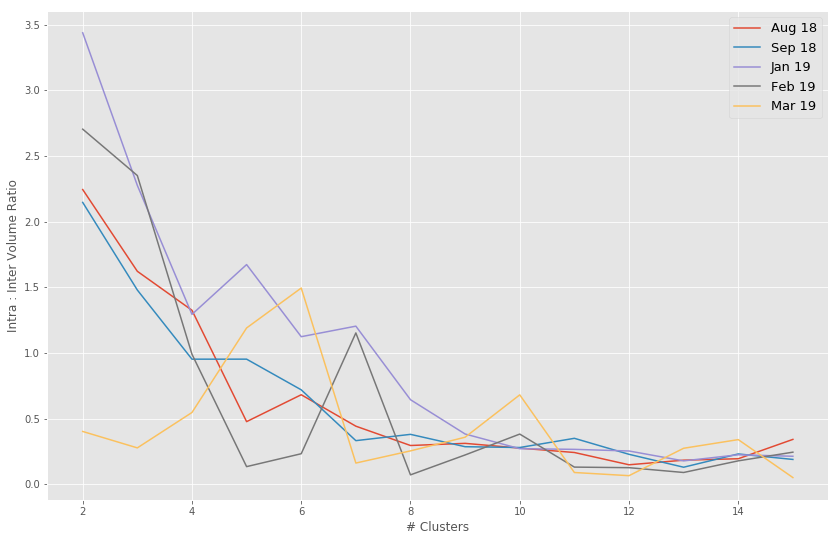

In [230]:
# df_plot = spec_clust_final.loc[spec_clust_final['month'] == "01"]['cluster']

from matplotlib.pyplot import figure
figure(figsize=(14, 9))

cluster_plot = spec_clust_final.loc[spec_clust_final['month'] == "01"]['cluster']

intra_inter_vol_plot_08 = spec_clust_final.loc[spec_clust_final['month'] == "08"]['intra_inter_vol']
intra_inter_vol_plot_09 = spec_clust_final.loc[spec_clust_final['month'] == "09"]['intra_inter_vol']
intra_inter_vol_plot_01 = spec_clust_final.loc[spec_clust_final['month'] == "01"]['intra_inter_vol']
intra_inter_vol_plot_02 = spec_clust_final.loc[spec_clust_final['month'] == "02"]['intra_inter_vol']
intra_inter_vol_plot_03 = spec_clust_final.loc[spec_clust_final['month'] == "03"]['intra_inter_vol']

plt.xlabel('# Clusters')
plt.ylabel('Intra : Inter Volume Ratio')

plt.plot(cluster_plot,intra_inter_vol_plot_08, label='Aug 18')
plt.plot(cluster_plot,intra_inter_vol_plot_09, label='Sep 18')
plt.plot(cluster_plot,intra_inter_vol_plot_01, label='Jan 19')
plt.plot(cluster_plot,intra_inter_vol_plot_02, label='Feb 19')
plt.plot(cluster_plot,intra_inter_vol_plot_03, label='Mar 19')
plt.legend(loc=1, prop={'size': 13})


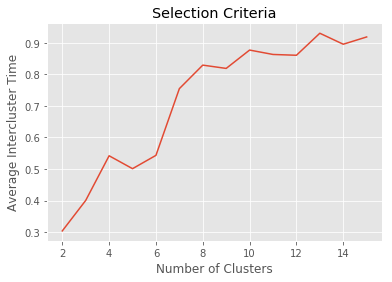

In [45]:
plt.plot(cluster_list,avg_inter_time_list)

plt.xlabel('Number of Clusters')
plt.ylabel('Average Intercluster Time')
plt.title('Selection Criteria')
plt.show()


### Generate a Dataframe that has the pertinent information for Data Visualization

In [141]:
station_clustered = list(zip(stations_sorted, clusters))
df_station_clustered = pd.DataFrame(station_clustered)
df_station_clustered.rename(columns={0:'station_id',
                                    1: 'cluster'},inplace=True)

start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

df_loc = pd.concat([start, end]).drop_duplicates()
df_all = df_loc.merge(df_station_clustered, on=["station_id"], how="right")
# df_all.to_csv("clusters_spectral_clustering.csv", index=None)
df_all.head()

,station_id,station_name,station_latitude,station_longitude,cluster
0,100,Bryant St at 15th St,37.767100,-122.410662,1
1,110,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,1
2,16,Steuart St at Market St,37.794130,-122.394430,2
3,343,Bryant St at 2nd St,37.783172,-122.393572,2
4,36,Folsom St at 3rd St,37.783830,-122.398870,2


### Code for generating the Intra : Inter Ratio

In [140]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(3, affinity='precomputed', n_init=100, assign_labels='discretize')
clusters = sc.fit_predict(sim_mat)

# select start station and trip count to new dataframe
intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

#define a mapping dictionary
cluster_dict = dict(zip(stations_sorted, clusters))

# map the clusters to the starting stations
intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)

# concat start and end cluster
intercluster_volume['start_end_cluster'] = intercluster_volume.cluster_i.map(str) + "|" + intercluster_volume.cluster_j.map(str)

# Group by start and end cluster summing the trip count and duration
intercluster_volume_grp = intercluster_volume.groupby('start_end_cluster', as_index=False)['trip_count','sum_duration_min'].sum()

# Figure out which are intra vs inter
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 1
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 0

intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 1
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 0

# get inter trip volume and duration time
intercluster_volume_grp['intercluster_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['trip_count']
intercluster_volume_grp['intercluster_time_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['sum_duration_min']

# get intra trip volume and duration time
intercluster_volume_grp['intracluster_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['trip_count']
intercluster_volume_grp['intracluster_time_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['sum_duration_min']

# make this i in the loop
intercluster_volume_grp['cluster_size'] = 3

intercluster_volume_grp_final = intercluster_volume_grp.groupby('cluster_size', as_index=False)['intercluster_volume','intercluster_time_volume', 'intracluster_volume', 'intracluster_time_volume'].sum()

intercluster_volume_grp_final['intra_inter_vol_ratio'] = intercluster_volume_grp_final['intracluster_volume'] / intercluster_volume_grp_final['intercluster_volume']
intercluster_volume_grp_final['intra_inter_time_ratio'] = intercluster_volume_grp_final['intracluster_time_volume'] / intercluster_volume_grp_final['intercluster_time_volume']

# print(intercluster_volume_grp_final['intercluster_volume'][0])

intercluster_volume_grp_final.head(15)


40.10970464135002


,cluster_size,intercluster_volume,intercluster_time_volume,intracluster_volume,intracluster_time_volume,intra_inter_vol_ratio,intra_inter_time_ratio
0,3,40.109705,30.505443,67.495359,44.48815,1.682769,1.458368


### Extra Code for single run of volume and time volume aggregation

In [73]:
# map clusters to roundtrip volume and rountrip volume time data

# select start station and trip count to new dataframe
intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

#define a mapping dictionary
cluster_dict = dict(zip(stations_sorted, clusters))

# map the clusters to the starting stations
intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)


intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intercluster_trip'] = 0 
intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intercluster_trip'] = 1 

intercluster_volume['intercluster_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['trip_count']
intercluster_volume['intercluster_time_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['sum_duration_min']

intercluster_volume.head()

,station_i,station_j,trip_count,sum_duration_min,cluster_i,cluster_j,intercluster_trip,intercluster_volume,intercluster_time_volume
0,100,100,8,72.833333,8,8,0.0,0.0,0.000000
1,100,101,7,18.816667,8,3,1.0,7.0,18.816667
2,100,102,9,40.783333,8,5,1.0,9.0,40.783333
3,100,104,11,106.333333,8,4,1.0,11.0,106.333333
4,100,105,6,54.516667,8,0,1.0,6.0,54.516667
